In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from skimage.transform import resize
from skimage.measure import compare_ssim, compare_psnr

In [ ]:
from sr_kspace import transforms as T

In [ ]:
import torch
import torch.nn as nn

In [ ]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [ ]:
def plot_img_and_spec(gray, fft, title='', figsize=(12, 6)):
    
    spectrum = np.log(fft + 1e-9)
    
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    
    axs[0].imshow(gray, cmap='gray', vmin=0, vmax=1)
    axs[1].imshow(spectrum, cmap='gray')
    
    axs[0].set_title(f'Source: {title}', fontsize=14)
    axs[1].set_title(f'Spectrum: {title}', fontsize=14)
    
    plt.show()


def tensor_for_model(tensor):
    tensor = tensor.transpose(-1, -2).transpose(-2, -3)
    tensor = tensor.unsqueeze(0)
    
    return tensor


def tensor_for_transform(tensor):
    tensor = tensor.transpose(-2, -3).transpose(-1, -2)
    tensor = tensor.squeeze(0)

    return tensor

In [ ]:
def compare_imgs(img_true, img_rec, verbose=True):

    img_true.squeeze()
    img_rec.squeeze()
    assert img_true.shape == img_rec.shape

    img_true = img_true.numpy() if isinstance(img_true, torch.Tensor) else img_true
    img_rec = img_rec.numpy() if isinstance(img_rec, torch.Tensor) else img_rec

    mae = abs(img_true - img_rec).mean()
    psnr = compare_psnr(img_true, img_rec)
    ssim = compare_ssim(img_true, img_rec)

    if verbose:
        print('\tMAE\tPSNR\tSSIM')
        print(f'score\t{mae:.3f}\t{psnr:.3f}\t{ssim:.3f}')

    return [mae, psnr, ssim]

## Load data

In [ ]:
PATH_TO_SOURCE_TRAIN = 'data/ax_t2_source_train'
PATH_TO_SOURCE_VAL = 'data/ax_t2_source_val'
PATH_TO_SOURCE_TEST = 'data/ax_t2_source_test'

PATH_TO_LR_TRAIN = 'data/ax_t2_re_im_160_train/'

PATH_TO_HR_MEAN_KSPACE = 'data/hr_mean_kspace.npy'
PATH_TO_LR_MEAN_KSPACE = 'data/lr_160_mean_kspace.npy'

RANDOM_STATE = 42

In [ ]:
samples = [s for s in os.listdir('data/ax_t2_source/') if s.endswith('npy')]

## HR k-space normalization

In [ ]:
samples = [s for s in os.listdir(PATH_TO_SOURCE_TRAIN) if s.endswith('npy')]

mean_k_space = np.zeros((320, 320), dtype=np.float32)

for s in tqdm(samples):
    slice = np.load(os.path.join(PATH_TO_SOURCE_TRAIN, s))[0]
    fft = np.fft.fft2(slice)
    fft = np.fft.fftshift(fft)
    data = np.stack((np.real(fft), np.imag(fft)), axis=-1)
    fft /= data.max()

    fft_abs = abs(fft)
    mean_k_space += fft_abs

mean_k_space /= len(samples)
with open(PATH_TO_HR_MEAN_KSPACE, 'wb') as f:
    pass
    #np.save(f, mean_k_space)

## LR k-space normalization

In [ ]:
lr_samples = [s for s in os.listdir(PATH_TO_LR_TRAIN) if s.endswith('npy')]

mean_k_space = np.zeros((160, 160), dtype=np.float32)

for s in tqdm(lr_samples):
    slice = np.load(os.path.join(PATH_TO_LR_TRAIN, s))
    k_space_abs = np.sqrt(slice[0]**2 + slice[1]**2)
    mean_k_space += k_space_abs

mean_k_space /= len(lr_samples)
with open(PATH_TO_LR_MEAN_KSPACE, 'wb') as f:
    pass
    #np.save(f, mean_k_space)

## Load normalization functions

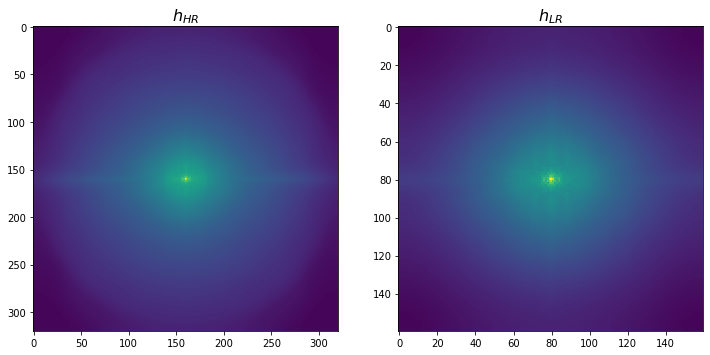

In [9]:
h_HR = np.load(PATH_TO_HR_MEAN_KSPACE)
h_LR = np.load(PATH_TO_LR_MEAN_KSPACE)

h_HR = torch.from_numpy(h_HR).unsqueeze(-1)
h_LR = torch.from_numpy(h_LR).unsqueeze(-1)

fig, axis = plt.subplots(1, 2, figsize=(12, 6))
axis[0].imshow(torch.log(h_HR[..., 0]))
axis[0].set_title(r'$h_{HR}$', fontsize=16)
axis[1].imshow(torch.log(h_LR[..., 0]))
axis[1].set_title(r'$h_{LR}$', fontsize=16)
plt.show()

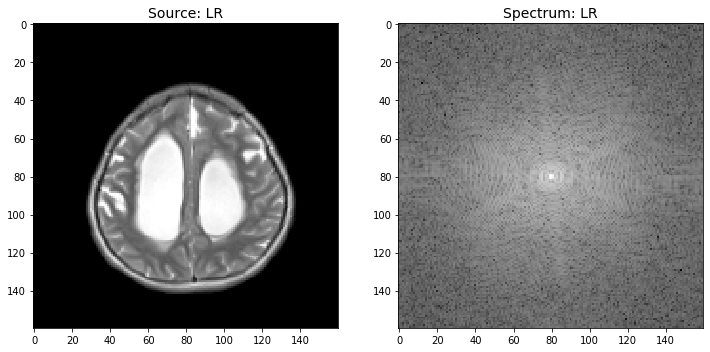

In [10]:
slice_lr = np.load(os.path.join('data/ax_t2_source', samples[0]))[0]
slice_lr = resize(slice_lr, (160, 160), preserve_range=True).astype(np.float32)
slice_sr = resize(slice_lr, (320, 320), preserve_range=True, order=3).astype(np.float32)
slice_sr = torch.from_numpy(slice_sr)

slice_lr = torch.from_numpy(slice_lr)
slice_lr = torch.stack([slice_lr, torch.zeros_like(slice_lr)], dim=-1)

k_space_lr = T.fft2(slice_lr)
k_space_lr /= k_space_lr.max()

plot_img_and_spec(slice_lr[..., 0], T.complex_abs(k_space_lr), title='LR')

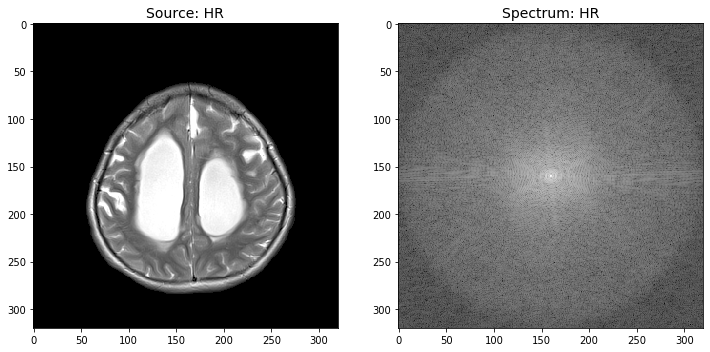

In [11]:
slice = np.load(os.path.join('data/ax_t2_source', samples[0]))[0]
slice = torch.from_numpy(slice)
slice = torch.stack([slice, torch.zeros_like(slice)], dim=-1)

k_space = T.fft2(slice)
k_space /= k_space.max()

plot_img_and_spec(slice[..., 0], T.complex_abs(k_space), title='HR')

## Train the simple SR model

In [12]:
class ResBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.start = nn.Sequential(nn.Conv2d(2, 64, 3, padding=1, bias=False),
                                  nn.ReLU()
                                  )

        self.body = nn.Sequential(nn.Conv2d(64, 64, 3, padding=1, bias=False),
                                  nn.BatchNorm2d(64, affine=False),
                                  nn.ReLU(),
                                  nn.Conv2d(64, 64, 3, padding=1, bias=False),
                                  nn.BatchNorm2d(64, affine=False)
                                 )  

        self.out = nn.Sequential(nn.Conv2d(64, 256, 3, padding=1, bias=False),
                                 nn.PixelShuffle(2),
                                 nn.ReLU(),
                                 nn.Conv2d(64, 2, 3, padding=1, bias=False)
                                )

    def forward(self, x):
        x = self.start(x)

        res = self.body(x)
        res += x

        return self.out(res)

In [13]:
torch.random.manual_seed(RANDOM_STATE)

model = ResBlock()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
losses = []

In [ ]:
for i in tqdm(range(2000)):
    out = model(tensor_for_model(k_space_lr/h_LR))
    out = tensor_for_transform(out) * h_HR
    out[80:240, 80:240] = out[80:240, 80:240] + k_space_lr

    out_img = T.k_space_to_image(out)

    loss = ((out_img - slice[..., 0])**2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

In [ ]:
plt.figure(figsize=(17, 5))
plt.plot(losses, 'b')
plt.title(f'Loss: {losses[-1]:.7f}', fontsize=14)
plt.yscale('log')
plt.grid()

plt.show()


out_img = out_img.detach()

print('SR results:')
compare_imgs(slice[..., 0], out_img)
print(f'MSE: {loss.item():.4f}')

print('\nInterpolation results:')
compare_imgs(slice[..., 0], slice_sr)
print(f'MSE: {((slice_sr - slice[..., 0])**2).mean():.4f}')

fig, axis = plt.subplots(3, 2, figsize=(14, 18))

axis[0, 0].imshow(slice[..., 0], cmap='gray')
axis[0, 0].set_title('HR image', fontsize=14)
axis[0, 1].imshow(torch.zeros_like(slice[..., 0]), cmap='gray')

axis[1, 0].imshow(out_img, cmap='gray')
axis[1, 1].imshow(abs(out_img - slice[..., 0]), cmap='gray', vmin=0, vmax=1)
axis[1, 0].set_title('Reconstructed image', fontsize=14)
axis[1, 1].set_title(r'Diff with HR', fontsize=14)

axis[2, 0].imshow(slice_sr, cmap='gray')
axis[2, 0].set_title('Bicubic interpolation', fontsize=14)
axis[2, 1].imshow(abs(slice_sr - slice[..., 0]), cmap='gray', vmin=0, vmax=1)

plt.show()

## 3D plot the normalization function

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(16, 14))
ax = fig.gca(projection='3d')
ax._axis3don = False

X = np.linspace(-1, 1, 500)
Y = np.linspace(-1, 1, 500)
X, Y = np.meshgrid(X, Y)
Z = np.exp((-X**2 - Y**2)/0.05)

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, rcount=200, ccount=200)



plt.show()